### DR5 color distributions using mixture of Gaussians

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table
from astropy.io import fits
from desitarget.targetmask import desi_mask, bgs_mask
from sklearn.mixture import GaussianMixture
from sklearn.cross_validation import train_test_split

import corner as cn

/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Select features to model

In [3]:
def keep(data):
    
    gflux = data['FLUX_G']
    rflux = data['FLUX_R']
    zflux = data['FLUX_Z']
    w1flux = data['FLUX_W1']
    w2flux = data['FLUX_W2']
    
    #only keep non-zero, non-negative flux values to convert to magnitudes
    good = (gflux > 0) & (rflux > 0) & (zflux > 0) & (w1flux > 0) & (w2flux > 0)

    gg = 22.5-2.5*np.log10(gflux[good])
    rr = 22.5-2.5*np.log10(rflux[good])
    zz = 22.5-2.5*np.log10(zflux[good])
    w1 = 22.5-2.5*np.log10(w1flux[good])
    w2 = 22.5-2.5*np.log10(w2flux[good])

    
    return np.array([gg, rr, zz, w1, w2]).T

#### Methods to sample from Gaussian

In [4]:
class GaussianMixtureModel(object):

    def __init__(self, weights, means, covars, covtype):
        self.weights = weights
        self.means = means
        self.covars = covars
        self.covtype = covtype
        self.n_components, self.n_dimensions = self.means.shape
    
    @staticmethod
    def save(model, filename):
        hdus = fits.HDUList()
        hdr = fits.Header()
        hdr['covtype'] = model.covariance_type
        hdus.append(fits.ImageHDU(model.weights_, name='weights', header=hdr))
        hdus.append(fits.ImageHDU(model.means_, name='means'))
        hdus.append(fits.ImageHDU(model.covariances_, name='covars'))
        hdus.writeto(filename, overwrite=True)

    @staticmethod
    def load(filename):
        hdus = fits.open(filename, memmap=False)
        hdr = hdus[0].header
        covtype = hdr['covtype']
        model = GaussianMixtureModel(
            hdus['weights'].data, hdus['means'].data, hdus['covars'].data, covtype)
        hdus.close()
        return model
        
    def sample(self, n_samples=1, random_state=None):
        
        if self.covtype != 'full':
            return NotImplementedError(
                'covariance type "{0}" not implemented yet.'.format(self.covtype))
        
        # Code adapted from sklearn's GMM.sample()
        if random_state is None:
            random_state = np.random.RandomState()

        weight_cdf = np.cumsum(self.weights)
        X = np.empty((n_samples, self.n_dimensions))
        rand = random_state.rand(n_samples)
        # decide which component to use for each sample
        comps = weight_cdf.searchsorted(rand)
        # for each component, generate all needed samples
        for comp in range(self.n_components):
            # occurrences of current component in X
            comp_in_X = (comp == comps)
            # number of those occurrences
            num_comp_in_X = comp_in_X.sum()
            if num_comp_in_X > 0:
                X[comp_in_X] = random_state.multivariate_normal(
                    self.means[comp], self.covars[comp], num_comp_in_X)
        return X
    
def get_bic(data, components_range):
    
    # Generate bic for each component in the range given
        
    bic = []
    for comp in components_range:
        model = GaussianMixture(n_components=comp, covariance_type='full')
        model.fit(data)
        bic.append(model.bic(data))
        #print('Component: {:d}'.format(comp))
    return bic

def plot_bic(bic, components_range, save=None):
    
    # Plot bic for each component
    
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.plot(components_range, np.asarray(np.asarray(bic)/100), marker='s', ls='-')
    ax.set_xlabel('Number of Gaussian Components')
    ax.set_ylabel('Bayesian Information Criterion/100')
    plt.title('Optimal number of components = {:d}'.format(np.argmin(bic)))
    if save:
        plt.savefig(save)
    plt.show()  


def make_gmm_model(X_data, components_range, model_filename=None, seed=123, bic_plot=False, save=None):
    
    # Create Gaussian Mixture Model based on optimal bic value
    
    # List of bic values for given range of components
    bic = get_bic(X_data, components_range)
    #option to plot bic values
    if bic_plot:
        plot_bic(bic, components_range, save)
    # Index of lowest bic value gives the optimal number of components
    n_comp = np.argmin(bic)
    gen = np.random.RandomState(seed)
    model = GaussianMixture(n_components=n_comp, covariance_type="full", random_state=gen).fit(X_data)
    if model_filename:
        GaussianMixtureModel.save(model, model_filename)
        print('Saved GMM as {:s}.'.format(model_filename))
    else:
        return model
    
def sample(filename, n_targets, random_state):
    
    # Sample from saved Gaussian Mixture Models
    model = GaussianMixtureModel.load(filename)
    return  model.sample(n_targets, random_state)

##### == from notebook on CORI ==

#### Read DR5 target catalog

`dr5 = Table.read('/global/project/projectdirs/desi/target/catalogs/targets-dr5-0.20.0.fits')
dr5[:5000000].write('data/dr5_subset.fits', overwrite=True)
dr5_subset = Table.read('data/dr5_subset.fits')`

#### Select targets that have passed selection cuts:


`desi_target, bgs_target, mws_target = apply_cuts(dr5_subset)`

`lrgs = dr5_subset[(desi_target & desi_mask.LRG).astype(bool)]
elgs = dr5_subset[(desi_target & desi_mask.ELG).astype(bool)]
qsos = dr5_subset[(desi_target & desi_mask.QSO).astype(bool)]
bgs = dr5_subset[(bgs_target & bgs_mask.BGS_BRIGHT).astype(bool)]`

`lrgs.write('cuts/lrg_dr5_subset_cuts.fits')
elgs.write('cuts/elg_dr5_subset_cuts.fits')
qsos.write('cuts/qso_dr5_subset_cuts.fits')
bgs.write('cuts/bgs_dr5_subset_cuts.fits')`

#### Load targets that have passed selection cuts by type

In [5]:
lrg = Table.read('data/cuts/lrg_dr5_subset_cuts.fits')
elg = Table.read('data/cuts/elg_dr5_subset_cuts.fits')
qso = Table.read('data/cuts/qso_dr5_subset_cuts.fits')
bgs = Table.read('data/cuts/bgs_dr5_subset_cuts.fits')

In [6]:
# Set up parameters for GMM

N = 10000

seed = 123
gen = np.random.RandomState(seed)

# Number of components to test for bic
components_range = range(1,40)

## LRG

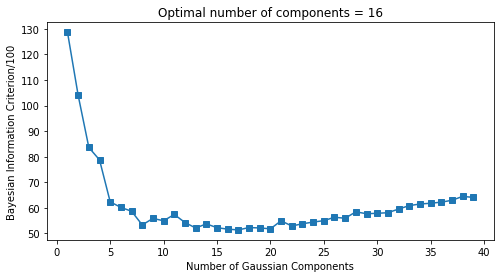

Saved GMM as data/gmm/lrg_colors_gmm.fits.


In [7]:
lrg_data = keep(lrg)

z = lrg_data[:,2]
r_z = lrg_data[:,1] - lrg_data[:,2]
z_w1 = lrg_data[:,2] - lrg_data[:,3]

lrg_colors = np.empty((len(lrg_data),3))
lrg_colors[:,0] = z
lrg_colors[:,1] = r_z
lrg_colors[:,2] = z_w1

lrg_train, lrg_valid = train_test_split(lrg_colors, test_size=0.5, random_state=gen)

# Make GMM model
make_gmm_model(lrg_train[:N], components_range, model_filename='data/gmm/lrg_colors_gmm.fits', 
               bic_plot=True)

# Sample GMM
lrg_GMM = sample('data/gmm/lrg_colors_gmm.fits', n_targets=N, random_state=gen)

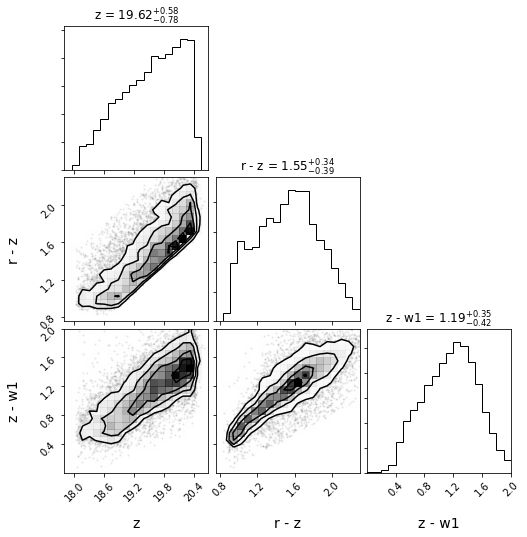

In [8]:
# Training data
fig = cn.corner(lrg_train[:N], labels=["z", "r - z", "z - w1"], range=[(17.8,20.7), (0.75,2.3), (0,2)], 
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

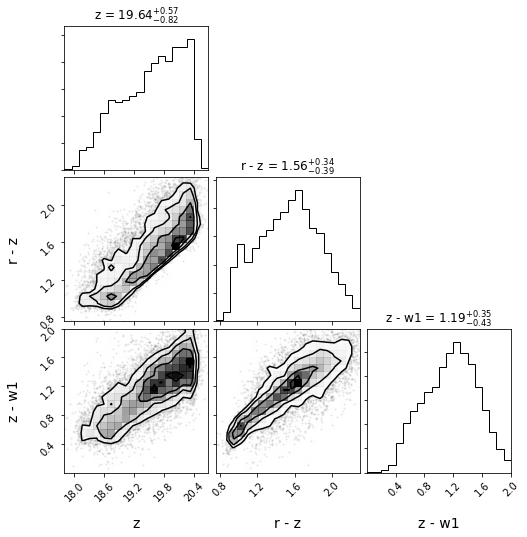

In [9]:
# Sampled from GMM
fig = cn.corner(lrg_GMM, labels=["z", "r - z", "z - w1"], range=[(17.8,20.7), (0.75,2.3), (0,2)], 
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

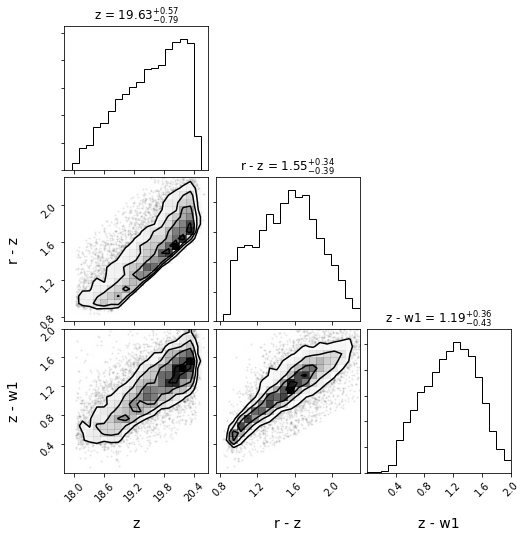

In [10]:
# Validation data
fig = cn.corner(lrg_valid[:N], labels=["z", "r - z", "z - w1"], range=[(17.8,20.7), (0.75,2.3), (0,2)], 
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

## ELG

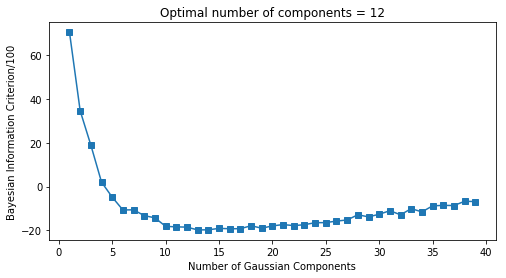

Saved GMM as data/gmm/elg_colors_gmm.fits.


In [11]:
elg_data = keep(elg)

r = elg_data[:,1]
g_r = elg_data[:,0] - elg_data[:,1]
r_z = elg_data[:,1] - elg_data[:,2]

elg_colors = np.empty((len(elg_data),3))
elg_colors[:,0] = r
elg_colors[:,1] = g_r
elg_colors[:,2] = r_z

elg_train, elg_valid = train_test_split(elg_colors, test_size=0.5, random_state=gen)

# Make GMM model
make_gmm_model(elg_train[:N], components_range, model_filename='data/gmm/elg_colors_gmm.fits', 
               bic_plot=True)

# Sample GMM
elg_GMM = sample('data/gmm/elg_colors_gmm.fits', n_targets=N, random_state=gen)

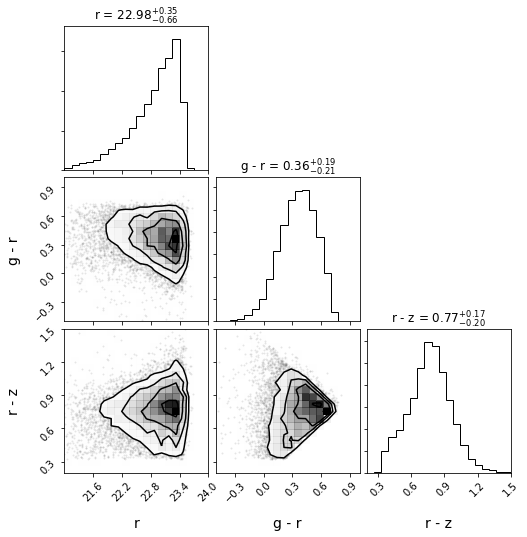

In [12]:
# Training data
fig = cn.corner(elg_train[:N], labels=["r", "g - r", "r - z"], range=[(21,24), (-0.5,1.0), (0.2,1.5)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

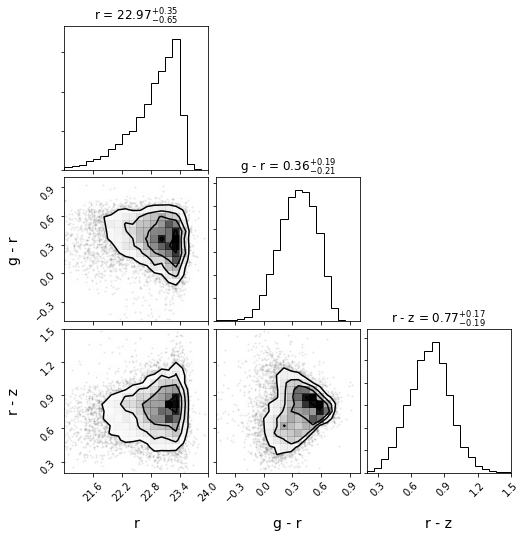

In [13]:
# Sampled from GMM
fig = cn.corner(elg_GMM, labels=["r", "g - r", "r - z"], range=[(21,24), (-0.5,1.0), (0.2,1.5)], 
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

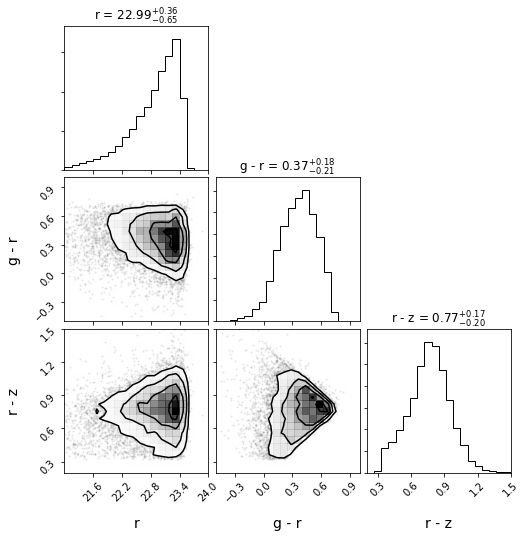

In [14]:
# Validation data
fig = cn.corner(elg_valid[:N], labels=["r", "g - r", "r - z"], range=[(21,24), (-0.5,1.0), (0.2,1.5)], 
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

## QSO

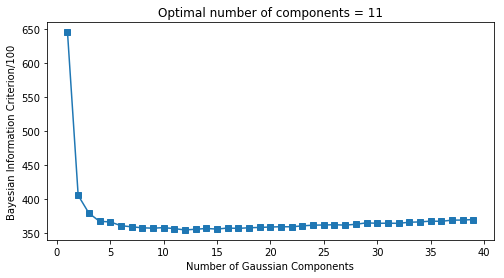

Saved GMM as data/gmm/qso_colors_gmm.fits.


In [15]:
qso_data = keep(qso)

r = qso_data[:,1]
g_r = qso_data[:,0] - qso_data[:,1]
r_z = qso_data[:,1] - qso_data[:,2]

qso_colors = np.empty((len(qso_data),3))
qso_colors[:,0] = r
qso_colors[:,1] = g_r
qso_colors[:,2] = r_z

qso_train, qso_valid = train_test_split(qso_colors, test_size=0.5, random_state=gen)

# Make GMM model
make_gmm_model(qso_train[:N], components_range, model_filename='data/gmm/qso_colors_gmm.fits', 
               bic_plot=True)

# Sample GMM
qso_GMM = sample('data/gmm/qso_colors_gmm.fits', n_targets=N, random_state=gen)

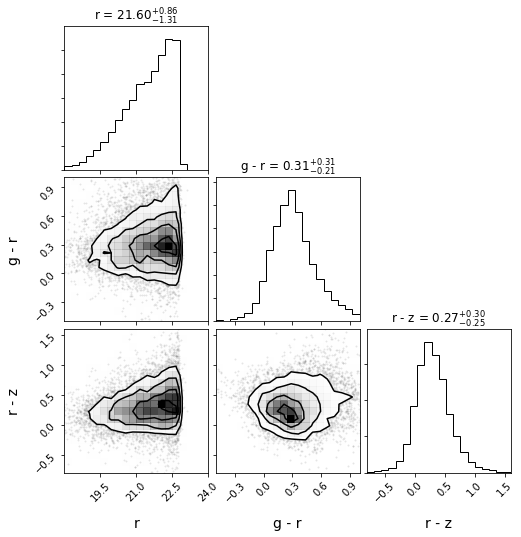

In [16]:
# Training data
fig = cn.corner(qso_train[:N], labels=["r", "g - r", "r - z"], 
                range=[(18,24), (-0.5,1), (-0.8,1.6)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

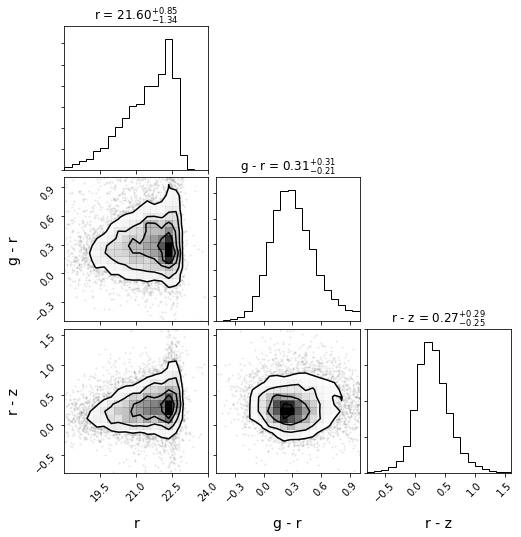

In [17]:
# Sampled from GMM
fig = cn.corner(qso_GMM, labels=["r", "g - r", "r - z"], 
                range=[(18,24), (-0.5,1), (-0.8,1.6)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

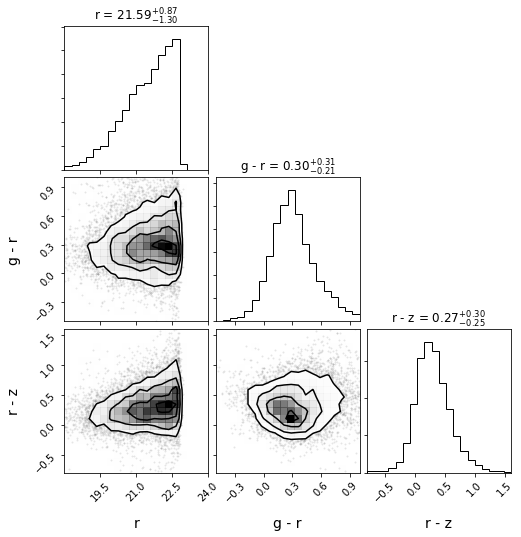

In [18]:
# Validation data
fig = cn.corner(qso_valid[:N], labels=["r", "g - r", "r - z"], 
                range=[(18,24), (-0.5,1), (-0.8,1.6)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

## BGS

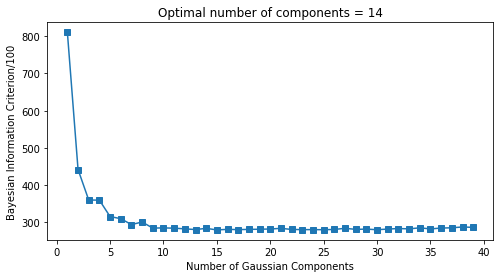

Saved GMM as data/gmm/bgs_colors_gmm.fits.


In [19]:
bgs_data = keep(bgs)

r = bgs_data[:,1]
g_r = bgs_data[:,0] - bgs_data[:,1]
r_z = bgs_data[:,1] - bgs_data[:,2]

bgs_colors = np.empty((len(bgs_data),3))
bgs_colors[:,0] = r
bgs_colors[:,1] = g_r
bgs_colors[:,2] = r_z

bgs_train, bgs_valid = train_test_split(bgs_colors, test_size=0.5, random_state=gen)

# Make GMM model
make_gmm_model(bgs_train[:N], components_range, model_filename='data/gmm/bgs_colors_gmm.fits', 
               bic_plot=True)

# Sample GMM
bgs_GMM = sample('data/gmm/bgs_colors_gmm.fits', n_targets=N, random_state=gen)

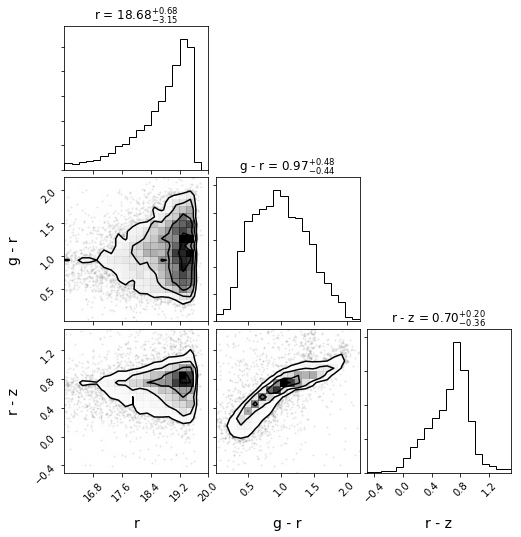

In [20]:
# Training data
fig = cn.corner(bgs_train[:N], labels=["r", "g - r", "r - z"], 
                range=[(16,20), (0,2.2), (-0.5,1.5)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

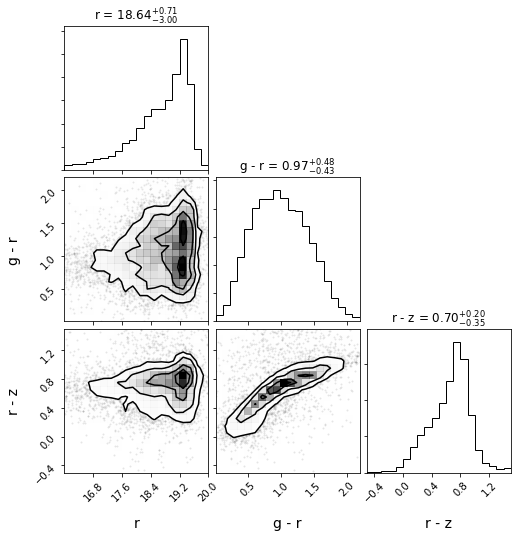

In [21]:
# Sampled from GMM
fig = cn.corner(bgs_GMM, labels=["r", "g - r", "r - z"], 
                range=[(16,20), (0,2.2), (-0.5,1.5)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})

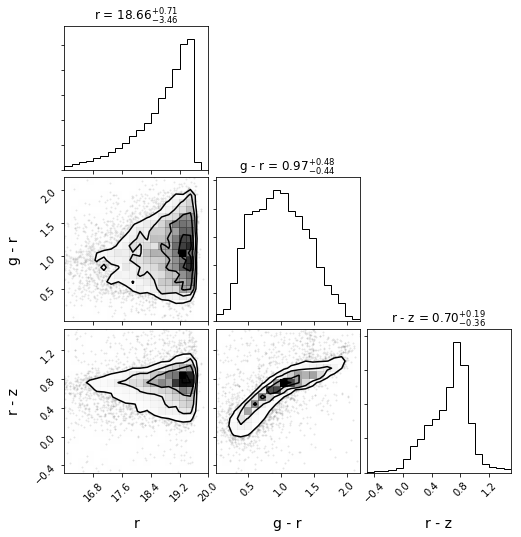

In [22]:
# Validation data
fig = cn.corner(bgs_valid[:N], labels=["r", "g - r", "r - z"], 
                range=[(16,20), (0,2.2), (-0.5,1.5)],
               label_kwargs={"fontsize": 14}, show_titles=True, title_kwargs={"fontsize": 12})